In [17]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import sys
import csv
import functools
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [18]:
# for set 1

In [19]:
df = pd.read_pickle("./4_MASDEV_Cleaned_S1.pkl")
df.shape

(76513, 41)

In [20]:
df["RECALL_CLASS"].value_counts()

0    48933
1    27580
Name: RECALL_CLASS, dtype: int64

<AxesSubplot:xlabel='RECALL_CLASS', ylabel='count'>

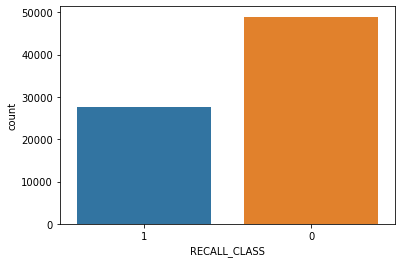

In [21]:
sns.countplot(x="RECALL_CLASS", data=df)

In [22]:
# creating dfs based on recall class
df_recall0 = df[df["RECALL_CLASS"] == "0"]
print(df_recall0.shape)
df_recall0.head()

(48933, 41)


,MDR_REPORT_KEY,MDR_TEXT_KEY,TEXT_TYPE_CODE,PATIENT_SEQUENCE_NUMBER,DATE_REPORT,FOI_TEXT,textLen,REPORT_NUMBER,REPORT_SOURCE_CODE,MANUFACTURER_LINK_FLAG_,...,DEVICE_REPORT_PRODUCT_CODE,DEVICE_AGE_TEXT,DEVICE_EVALUATED_BY_MANUFACTUR,year,STD_MANUFACTURER,STD_DEVICE,RECALL_CLASS,CENSORED,_merge,CLEAN_FOI_TEXT
5,263098,147618,D,1,NaN,OVERSENSING FROM LEAD FRACTURE CAUSED PT TO RE...,NaN,2182208-2000-00025,M,Y,...,LWS,12 MO,Y,2000,MEDTRONIC,MEDTRONIC_SPRINT,0,2000-01-10,both,oversens lead fractur caus pt receiv unnecessa...
21,291837,148901,D,1,NaN,"SYSTEM RETURNED FOR LEAD FRACTURES, BURN MARK ...",NaN,2649622-2000-00207,M,Y,...,LWS,36 MO,Y,2000,MEDTRONIC,MEDTRONIC_SPRINT,0,2000-05-12,both,system return lead fractur burn mark long char...
25,292539,182872,D,1,NaN,PACING THRESHOLD INCREASE,NaN,2649622-2000-00385,M,Y,...,LWS,24 MO,Y,2000,MEDTRONIC,MEDTRONIC_SPRINT,0,2000-07-11,both,pace threshold increas
26,292547,182873,D,1,NaN,"SENSING DIFFICULTY, INSULATION DAMAGE",NaN,2182208-2000-00251,M,Y,...,LWS,24 MO,Y,2000,MEDTRONIC,MEDTRONIC_SPRINT,0,2000-07-11,both,sens difficulti insul damag
28,292558,20930497,D,1,NaN,"APPARENT LEAD FRACTURE, NOISE.",NaN,2649622-2000-00364,M,Y,...,LWS,12 MO,Y,2000,MEDTRONIC,MEDTRONIC_SPRINT,0,2000-07-11,both,appar lead fractur nois


In [23]:
df_recall1 = df[df["RECALL_CLASS"] == "1"]
print(df_recall1.shape)
df_recall1.head()

(27580, 41)


,MDR_REPORT_KEY,MDR_TEXT_KEY,TEXT_TYPE_CODE,PATIENT_SEQUENCE_NUMBER,DATE_REPORT,FOI_TEXT,textLen,REPORT_NUMBER,REPORT_SOURCE_CODE,MANUFACTURER_LINK_FLAG_,...,DEVICE_REPORT_PRODUCT_CODE,DEVICE_AGE_TEXT,DEVICE_EVALUATED_BY_MANUFACTUR,year,STD_MANUFACTURER,STD_DEVICE,RECALL_CLASS,CENSORED,_merge,CLEAN_FOI_TEXT
38507,5243499,31980136,D,1,NaN,INAPPROPRIATE SHOCK FROM SENSING NOISE IN BOST...,NaN,MW5058024,P,N,...,LWS,NaN,*,2015,BOSTON SCIENTIFIC,BOS_SCI_EMBLEM,1,2015-11-18,both,inappropri shock sens nois mfgid model subcuta...
39392,5311483,34152024,D,1,NaN,"PATIENT RECEIVED MULTIPLE SHOCKS DUE TO ""NOISE...",NaN,MW5058599,P,N,...,LWS,NaN,*,2015,BOSTON SCIENTIFIC,BOS_SCI_EMBLEM,1,2015-12-16,both,patient receiv multipl shock due nois first sh...
39733,5366177,36215847,D,1,NaN,PT HAD AICD INSERTED ON (B)(6) 2015 AT (B)(6) ...,NaN,MW5059313,P,N,...,LWS,NaN,*,2016,BOSTON SCIENTIFIC,BOS_SCI_EMBLEM,1,2016-01-11,both,pt aicd insert hospit hospit remov lead fire s...
43667,5790937,49435460,D,1,NaN,BOSTON SCIENTIFIC RECEIVED INFORMATION THAT TH...,NaN,2124215-2016-09705,M,Y,...,LWS,DA,R,2016,BOSTON SCIENTIFIC,BOS_SCI_EMBLEM,1,2016-07-13,both,mfgid receiv inform thi subcutan implant cardi...
43681,5791726,49516690,D,1,NaN,PT HAD SUBCUTANEOUS ICD PROCEDURE. DURING THE ...,NaN,5791726,U,N,...,LWS,NaN,I,2016,BOSTON SCIENTIFIC,BOS_SCI_EMBLEM,1,2016-07-09,both,pt subcutan icd procedur the cours the introdu...


In [24]:
# undersampling
udf_recall0 = df_recall0.sample(n=27580)
print(udf_recall0.shape)
udf_recall1 = df_recall1.sample(n=27580)
print(udf_recall1.shape)

(27580, 41)
(27580, 41)


(55160, 41)


<AxesSubplot:xlabel='RECALL_CLASS', ylabel='count'>

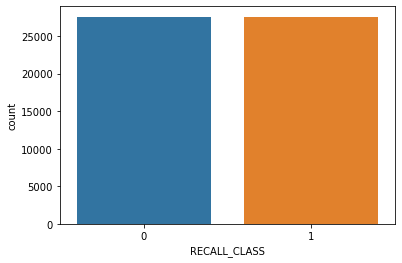

In [25]:
udf = udf_recall0
udf = udf.append(udf_recall1)
print(udf.shape)
sns.countplot(x="RECALL_CLASS", data=udf)

In [26]:
# oversampling
odfsame_recall1 = pd.concat([df_recall1]*2, ignore_index=True)
odfsame_recall1 = odfsame_recall1.sample(n=48933)
print(odfsame_recall1.shape)

(48933, 41)


(97866, 41)


<AxesSubplot:xlabel='RECALL_CLASS', ylabel='count'>

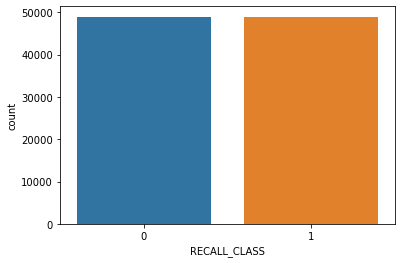

In [27]:
odfsame = df_recall0
odfsame = odfsame.append(odfsame_recall1)
print(odfsame.shape)
sns.countplot(x="RECALL_CLASS", data=odfsame)

In [45]:
udf.to_pickle("./4_COMB_FILE_UNDERSAMPLING_S1.pkl")
print(udf.shape)
odfsame.to_pickle("./4_COMB_FILE_OVERSAMPLING_S1.pkl")
print(odfsame.shape)
df.to_pickle("./4_COMB_FILE_UNBALANCED_S1.pkl")
print(df.shape)

(55160, 41)
(97866, 41)
(76513, 41)


In [29]:
# for set 2

In [30]:
df2 = pd.read_pickle("./4_MASDEV_Cleaned_S2.pkl")
df2.shape

(4432, 41)

In [31]:
df2["RECALL_CLASS"].value_counts()

1    2333
0    2099
Name: RECALL_CLASS, dtype: int64

<AxesSubplot:xlabel='RECALL_CLASS', ylabel='count'>

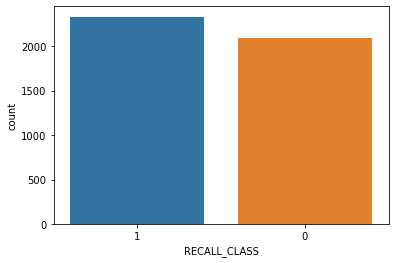

In [32]:
sns.countplot(x="RECALL_CLASS", data=df2)

In [33]:
# creating dfs based on recall class
df2_recall0 = df2[df2["RECALL_CLASS"] == "0"]
print(df2_recall0.shape)
df2_recall0.head()

(2099, 41)


,MDR_REPORT_KEY,MDR_TEXT_KEY,TEXT_TYPE_CODE,PATIENT_SEQUENCE_NUMBER,DATE_REPORT,FOI_TEXT,textLen,REPORT_NUMBER,REPORT_SOURCE_CODE,MANUFACTURER_LINK_FLAG_,...,DEVICE_REPORT_PRODUCT_CODE,DEVICE_AGE_TEXT,DEVICE_EVALUATED_BY_MANUFACTUR,year,STD_MANUFACTURER,STD_DEVICE,RECALL_CLASS,CENSORED,_merge,CLEAN_FOI_TEXT
5365,1499570,1175091,D,1,NaN,IT WAS REPORTED THAT THE SVC LEAD IMPEDANCE HA...,NaN,2182208-2009-00315,M,Y,...,LWS,4 YR,Y,2009,MEDTRONIC,MEDTRONIC_SUBQ,0,2009-10-09,both,it report the svc lead imped been trend normal...
6323,1555575,21787851,D,1,NaN,IT WAS REPORTED THE LEAD CAPPED AND REPLACED D...,NaN,2182208-2009-00385,M,Y,...,LWS,2 YR,Y,2009,MEDTRONIC,MEDTRONIC_SUBQ,0,2009-12-10,both,it report lead cap replac due high imped a fra...
6504,1646154,1334607,D,1,NaN,"THE LEAD WAS RETURNED TO THE MANUFACTURER, ANA...",NaN,2182208-2010-00146,M,Y,...,LWS,2 YR,Y,2010,MEDTRONIC,MEDTRONIC_SUBQ,0,2010-03-30,both,the lead return the manufactur analyz subsequ ...
6698,1842687,1373403,D,1,NaN,IT WAS REPORTED THAT THE PATIENT WAS ADMITTED ...,NaN,2182208-2010-00631,M,Y,...,LWS,5 YR,N,2010,MEDTRONIC,MEDTRONIC_SUBQ,0,2010-09-23,both,it report the patient admit the hospit episod ...
7019,1861905,1467006,D,1,NaN,IT WAS REPORTED THAT THE PATIENT'S LEAD IMPEDA...,NaN,2182208-2010-00714,M,Y,...,LWS,8 YR,N,2010,MEDTRONIC,MEDTRONIC_SUBQ,0,2010-10-08,both,it report the patient lead imped variabl the l...


In [34]:
df2_recall1 = df2[df2["RECALL_CLASS"] == "1"]
print(df2_recall1.shape)
df2_recall1.head()

(2333, 41)


,MDR_REPORT_KEY,MDR_TEXT_KEY,TEXT_TYPE_CODE,PATIENT_SEQUENCE_NUMBER,DATE_REPORT,FOI_TEXT,textLen,REPORT_NUMBER,REPORT_SOURCE_CODE,MANUFACTURER_LINK_FLAG_,...,DEVICE_REPORT_PRODUCT_CODE,DEVICE_AGE_TEXT,DEVICE_EVALUATED_BY_MANUFACTUR,year,STD_MANUFACTURER,STD_DEVICE,RECALL_CLASS,CENSORED,_merge,CLEAN_FOI_TEXT
44671,5863406,51873032,D,1,NaN,IT WAS REPORTED THAT RIGHT VENTRICULAR (RV) LE...,NaN,3004209178-2016-16452,M,Y,...,LWS,DA,*,2016,MEDTRONIC,MEDTRONIC_VISIA,1,2016-08-09,both,it report right ventricular rv lead undersens ...
45409,6005362,56757732,D,1,NaN,IT WAS REPORTED THAT APPROXIMATELY 1 MONTH AFT...,NaN,3004209178-2016-20658,M,Y,...,LWS,DA,*,2016,MEDTRONIC,MEDTRONIC_VISIA,1,2016-10-06,both,it report approxim month implant the implant c...
45746,6008518,56782074,D,1,NaN,IT WAS REPORTED THAT POST IMPLANT THE PATIENT ...,NaN,3004209178-2016-20876,M,Y,...,LWS,DA,*,2016,MEDTRONIC,MEDTRONIC_VISIA,1,2016-10-06,both,it report post implant patient develop centime...
46980,6162782,62086281,D,1,NaN,IT WAS REPORTED THAT THE PATIENT WAS EXPERIENC...,NaN,3004209178-2016-25929,M,Y,...,LWS,DA,Y,2016,MEDTRONIC,MEDTRONIC_VISIA,1,2016-12-09,both,it report the patient experienc pain the impla...
47133,6162236,62104496,D,1,NaN,IT WAS REPORTED THAT THE PATIENT HAD A LEAD AL...,NaN,3004209178-2016-25845,M,Y,...,LWS,DA,Y,2016,MEDTRONIC,MEDTRONIC_VISIA,1,2016-12-09,both,it report the patient a lead alert indic right...


In [35]:
# undersampling
udf2_recall0 = df2_recall0.sample(n=2099)
print(udf2_recall0.shape)
udf2_recall1 = df2_recall1.sample(n=2099)
print(udf2_recall1.shape)

(2099, 41)
(2099, 41)


(4198, 41)


<AxesSubplot:xlabel='RECALL_CLASS', ylabel='count'>

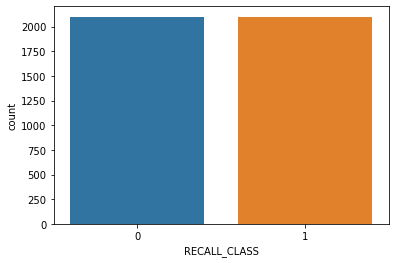

In [36]:
udf2 = udf2_recall0
udf2 = udf2.append(udf2_recall1)
print(udf2.shape)
sns.countplot(x="RECALL_CLASS", data=udf2)

In [38]:
# oversampling
odf2same_recall0 = pd.concat([df2_recall0]*2, ignore_index=True)
odf2same_recall0 = odf2same_recall0.sample(n=2333)
print(odf2same_recall0.shape)

(2333, 41)


(4666, 41)


<AxesSubplot:xlabel='RECALL_CLASS', ylabel='count'>

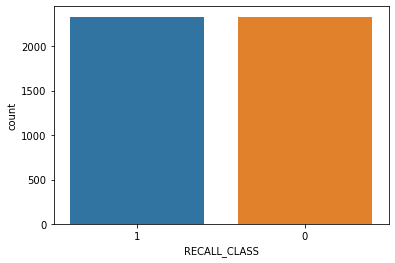

In [39]:
odf2same = df2_recall1
odf2same = odf2same.append(odf2same_recall0)
print(odf2same.shape)
sns.countplot(x="RECALL_CLASS", data=odf2same)

In [44]:
udf2.to_pickle("./4_COMB_FILE_UNDERSAMPLING_S2.pkl")
print(udf2.shape)
odf2same.to_pickle("./4_COMB_FILE_OVERSAMPLING_S2.pkl")
print(odf2same.shape)
df2.to_pickle("./4_COMB_FILE_UNBALANCED_S2.pkl")
print(df2.shape)

(4198, 41)
(4666, 41)
(4432, 41)


In [43]:
# different variations of oversampling were not used due to the relative similarity of the recall class sizes